In [1]:
import numpy as np
import theano
import theano.tensor as T

In [2]:
def single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt, exp):
    Area = np.pi * D**2.0 / 4.0
    m = 1.0 / (sqrt(1.0 - CT))
    k = sqrt((m + 1.0) / 2.0)
    R96 = a1 * (exp(a2 * CT**2.0 + a3 * CT + a4)) * (b1 * TI + b2) * D
    x0 = (9.6 * D) / ((2.0 * R96 / (k * D))**3.0 - 1.0)
    term1 = (k * D / 2.0)**2.5
    term2 = (105.0/(2.0*np.pi))**-0.5
    term3 = (CT * Area * x0)**(-5.0 / 6.0)
    c1 = term1 * term2 * term3
    Rw = ((105.0 * c1**2.0 / (2.0 * np.pi))**0.2) * (CT * Area * (x + x0))**(1.0 / 3.0)
    term10=(1./9.)
    term20=(CT*Area*(x+x0)**(-2.))**(1./3.)
    term310=(r**(1.5))
    term320=(3.*c1*c1*CT*Area*(x+x0))**(-0.5)
    term30=term310*term320
    term41=(35./(2.*np.pi))**(3./10.)
    term42=(3.*c1*c1)**(-0.2)
    term40=term41*term42
    dU1=-term10*term20*(term30-term40)**2.
    return dU1, Rw

In [3]:
# gcl = theano.function(inputs=[x, r, CT, TI, D, a1, a2, a3, a4, b1, b2], outputs=[dU, Rw])
D, TI, CT, x, r = T.dmatrices("D", "TI", "CT", "x", "r")
#a1, a2, a3, a4, b1, b2 = T.dvectors("a1", "a2", "a3", "a4", "b1", "b2")
a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]

dU, Rw = single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt=T.sqrt, exp=T.exp)

# A bit of Theano black magic to do:
# dU[Rw<R_]=0.0 
dU2 = T.set_subtensor(dU[(Rw<r).nonzero()], 0.0)

# dU[X_<0.0]=0.0
dU3 = T.set_subtensor(dU2[(x<0.).nonzero()], 0.0)

gcl_theano = theano.function([x, r, D, TI, CT], [dU3, Rw])

In [4]:
gcl_numpy = lambda x, r, D, TI, CT: single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt=np.sqrt, exp=np.exp)

In [13]:
wt_D = 80.0
N = 1000
xs = np.linspace(-2, 10, N) * wt_D
rs = np.linspace(-3, 3, N) * wt_D
x, r = np.meshgrid(xs, rs)
X_ = x
R_ = abs(r)
D_ = wt_D * np.ones_like(X_)
CT_ = 0.80 * np.ones_like(X_)
TI_ = 0.01 * np.ones_like(X_)
#a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]
#a1 *= np.ones_like(x)
#a2 *= np.ones_like(x)
#a3 *= np.ones_like(x)
#b1 *= np.ones_like(x)
#b2 *= np.ones_like(x)

In [6]:
%%timeit
gcl_theano(X_, R_, CT_, TI_, D_)

1 loop, best of 3: 2.01 s per loop


In [7]:
%%timeit
gcl_numpy(X_, R_, CT_, TI_, D_)

1 loop, best of 3: 4.05 s per loop


In [8]:
X_.shape

(3000, 3000)

In [14]:
dU, Rw = gcl_theano(X_, R_, D_, TI_, CT_)
#dU, Rw = single_wake(X_, R_, D_, TI_, CT_, a1, a2, a3, a4, b1, b2, sqrt=np.sqrt, exp=np.exp)

#dU[Rw<R_]=0.0
#dU[X_<0.0]=0.0

In [17]:
from matplotlib import pylab as plt
%matplotlib inline

(-160.0, 800.0, -240.0, 240.0)

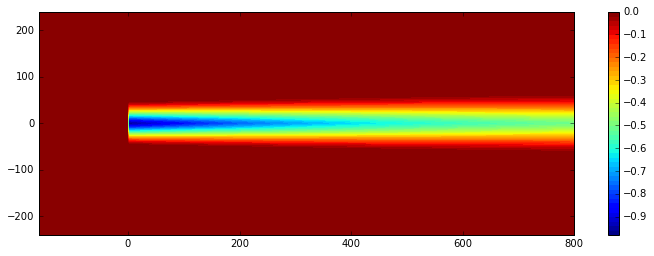

In [18]:
plt.figure(figsize=(12,4))
plt.contourf(xs, rs, dU, 50)
plt.colorbar()
plt.axis('tight')

## Playing with scan

In [68]:
def power_of_2(previous_power, max_value):
    return previous_power*2, theano.scan_module.until(previous_power*2 > max_value)

max_value = T.scalar()
values, _ = theano.scan(power_of_2,
                        outputs_info = T.constant(4.),
                        non_sequences = max_value,
                        n_steps = 1024)

f = theano.function([max_value], values)

print(f(45))

[  8.  16.  32.  64.]


## Building a meshgrid for Theano

In [19]:
x = np.linspace(-10, 10, 20)
R = np.linspace(40, 50, 30)

X_np, R_np = np.meshgrid(x,R)
X_.shape

(1000, 1000)

In [20]:
def test_mesh(X_, R_):
    np.testing.assert_array_almost_equal(X_np, X_)
    np.testing.assert_array_almost_equal(R_np, R_)

In [21]:
def meshgrid(A, B, tile):
    """Theano friendly meshgrid
    """
    return tile(A, (B.size, 1)), tile(B, (A.size, 1)).T

Testing the meshgrid in pure numpy

In [22]:
test_mesh(*meshgrid(x,R, np.tile))

This seems to work fine

#### Building the Theano function

In [23]:
Tx, Tr = T.vectors('x', 'r')
TX, TR = meshgrid(Tx, Tr, T.tile)
Tmeshgrid = theano.function([Tx, Tr], [TX, TR])

running the function

In [24]:
test_mesh(*Tmeshgrid(x, R))

All test are passing, Yay!

## Rotor integration 

In [40]:
def get_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight, 
    a1, a2, a3, a4, b1, b2, O=np):
    """Computes the wake velocity deficit at a location

    Inputs
    ----------
    x: float or array
        Distance between wake generating turbines and wake operating
        turbines in the streamwise direction
    y: float or array
        Distance between wake generating turbines and wake operating
        turbine in the crossflow horizontal direction
    z: float or array
        Distance between wake generating turbines and wake operating
        turbine in the crossflow vertical direction
    RT: float
        Wake operating turbine's radius [m]
    R: float or array
        Wake generating turbine's radius [m]
    TI: float
        Ambient turbulence intensity for the wake generating turbine [-]
    CT: float
        Thrust coefficient for the wake generating turbine [-]
    order: int, optional

    Returns
    -------
    dUeq: float
        Rotor averaged wake velocity deficit for each wake operating WT
    """

    # New improved quadrature rule for wake deficit rotor averaging


    x_msh, node_R_msh = meshgrid(x, node_R, O.tile)
    y_msh, node_th_msh = meshgrid(y, node_th, O.tile)
    z_msh, weight_msh = meshgrid(z, weight, O.tile)

    xe = x_msh
    ye = y_msh + RT * node_R_msh * O.cos(node_th_msh)
    ze = z_msh + RT * node_R_msh * O.sin(node_th_msh)
    re = O.sqrt( ye**2. + ze**2. )

    dU_msh, Rw = single_wake(xe, re, 2.0*R, CT, TI, a1, a2, a3, a4, b1, b2, sqrt=O.sqrt, exp=O.exp)
    dUeq = O.sum(weight_msh * dU_msh, axis=0)

    return dUeq

Definition of the nodes

In [41]:
node_R, node_th, weight = np.array([
    [ 0.26349922998554242692 ,  4.79436403870179805864 ,  0.00579798753740115753 ],
    [ 0.26349922998554242692 ,  5.13630491629471475079 ,  0.01299684397858970851 ],
    [ 0.26349922998554242692 ,  5.71955352542765460555 ,  0.01905256317618122044 ],
    [ 0.26349922998554242692 ,  0.20924454049880022999 ,  0.02341643323656225281 ],
    [ 0.26349922998554242692 ,  1.10309379714216659885 ,  0.02569988335562909190 ],
    [ 0.26349922998554242692 ,  2.03849885644762496284 ,  0.02569988335562912660 ],
    [ 0.26349922998554242692 ,  2.93234811309099407950 ,  0.02341643323656214179 ],
    [ 0.26349922998554242692 ,  3.70522443534172518653 ,  0.01905256317618119616 ],
    [ 0.26349922998554242692 ,  4.28847304447466459720 ,  0.01299684397858971198 ],
    [ 0.26349922998554242692 ,  4.63041392206758217753 ,  0.00579798753740114539 ],
    [ 0.57446451431535072718 ,  4.79436403870179805864 ,  0.01086984853977092380 ],
    [ 0.57446451431535072718 ,  5.13630491629471475079 ,  0.02436599330905551281 ],
    [ 0.57446451431535072718 ,  5.71955352542765460555 ,  0.03571902745281423097 ],
    [ 0.57446451431535072718 ,  0.20924454049880022999 ,  0.04390024659093685194 ],
    [ 0.57446451431535072718 ,  1.10309379714216659885 ,  0.04818117282305908744 ],
    [ 0.57446451431535072718 ,  2.03849885644762496284 ,  0.04818117282305915683 ],
    [ 0.57446451431535072718 ,  2.93234811309099407950 ,  0.04390024659093664378 ],
    [ 0.57446451431535072718 ,  3.70522443534172518653 ,  0.03571902745281418240 ],
    [ 0.57446451431535072718 ,  4.28847304447466459720 ,  0.02436599330905552321 ],
    [ 0.57446451431535072718 ,  4.63041392206758217753 ,  0.01086984853977089951 ],
    [ 0.81852948743000586429 ,  4.79436403870179805864 ,  0.01086984853977090992 ],
    [ 0.81852948743000586429 ,  5.13630491629471475079 ,  0.02436599330905548505 ],
    [ 0.81852948743000586429 ,  5.71955352542765460555 ,  0.03571902745281418934 ],
    [ 0.81852948743000586429 ,  0.20924454049880022999 ,  0.04390024659093679643 ],
    [ 0.81852948743000586429 ,  1.10309379714216659885 ,  0.04818117282305903193 ],
    [ 0.81852948743000586429 ,  2.03849885644762496284 ,  0.04818117282305909438 ],
    [ 0.81852948743000586429 ,  2.93234811309099407950 ,  0.04390024659093658826 ],
    [ 0.81852948743000586429 ,  3.70522443534172518653 ,  0.03571902745281413383 ],
    [ 0.81852948743000586429 ,  4.28847304447466459720 ,  0.02436599330905549199 ],
    [ 0.81852948743000586429 ,  4.63041392206758217753 ,  0.01086984853977088737 ],
    [ 0.96465960618086743494 ,  4.79436403870179805864 ,  0.00579798753740116100 ],
    [ 0.96465960618086743494 ,  5.13630491629471475079 ,  0.01299684397858971545 ],
    [ 0.96465960618086743494 ,  5.71955352542765460555 ,  0.01905256317618123432 ],
    [ 0.96465960618086743494 ,  0.20924454049880022999 ,  0.02341643323656226669 ],
    [ 0.96465960618086743494 ,  1.10309379714216659885 ,  0.02569988335562910925 ],
    [ 0.96465960618086743494 ,  2.03849885644762496284 ,  0.02569988335562914394 ],
    [ 0.96465960618086743494 ,  2.93234811309099407950 ,  0.02341643323656215567 ],
    [ 0.96465960618086743494 ,  3.70522443534172518653 ,  0.01905256317618120657 ],
    [ 0.96465960618086743494 ,  4.28847304447466459720 ,  0.01299684397858972065 ],
    [ 0.96465960618086743494 ,  4.63041392206758217753 ,  0.00579798753740114886 ]]).T

In [42]:
a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]

In [43]:
D = 80.
R = D/2.
RT = 90./2.
CT = 0.89
TI = 0.1
x = np.linspace(1., 10., 100) * D
y = np.zeros_like(x)
z = np.zeros_like(x)

The pure python way

In [44]:
dUeq = get_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight, a1, a2, a3, a4, b1, b2)

The Theano way

In [78]:
Tx, Ty, Tz, Tnode_R, Tnode_th, Tweight = T.vectors('Tx', 'Ty', 'Tz', 'Tnode_R', 'Tnode_th', 'Tweight')
TRT, TR, TCT, TTI = T.scalars('TRT', 'TR', 'TCT', 'TTI')
TdUeq = get_dUeq(Tx, Ty, Tz, TRT, TR, TCT, TTI, Tnode_R, Tnode_th, Tweight, a1, a2, a3, a4, b1, b2, O=T)
Tget_dUeq = theano.function([Tx, Ty, Tz, TRT, TR, TCT, TTI, Tnode_R, Tnode_th, Tweight], TdUeq)

In [60]:
dUeqT = Tget_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight)

In [64]:
np.testing.assert_array_almost_equal(dUeq, dUeqT)

It's working!

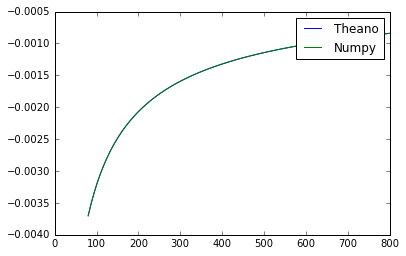

In [63]:
plt.plot(x, dUeqT, label='Theano')
plt.plot(x, dUeq, label='Numpy')
plt.legend()

Benchmarking

In [72]:
N = 100000
x = np.linspace(1., 10., N) * D
y = np.zeros_like(x)
z = np.zeros_like(x)

In [73]:
%%timeit
Tget_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight)

1 loop, best of 3: 898 ms per loop


In [74]:
%%timeit
get_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight, a1, a2, a3, a4, b1, b2)

1 loop, best of 3: 1.9 s per loop


Theano is about twice as fast as numpy

### Funs with analytical gradients.

We calculate the gradient of the sum of dUeq with respect to x

In [ ]:
Tsum = TdUeq.sum()
gradsum = T.grad(Tsum, Tx)

In [87]:
ddUeq = theano.function([Tx, Ty, Tz, TRT, TR, TCT, TTI, Tnode_R, Tnode_th, Tweight], gradsum)

In [88]:
ddUeqT = ddUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight)

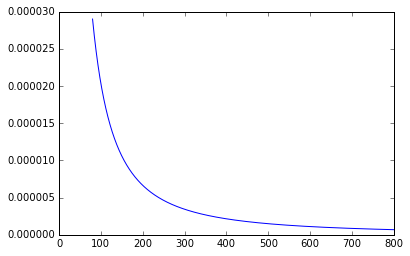

In [89]:
plt.plot(x, ddUeqT, label='gradients')